In [86]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
import numpy as np


--- Categorical Naive Bayes ---
Accuracy: 0.8333333333333334
Precision: 0.8569444444444444
Recall: 0.8333333333333334
F1 Score: 0.8228114478114478
Confusion Matrix:
 [[3 1 0 0]
 [0 5 0 0]
 [0 0 8 0]
 [1 0 2 4]]


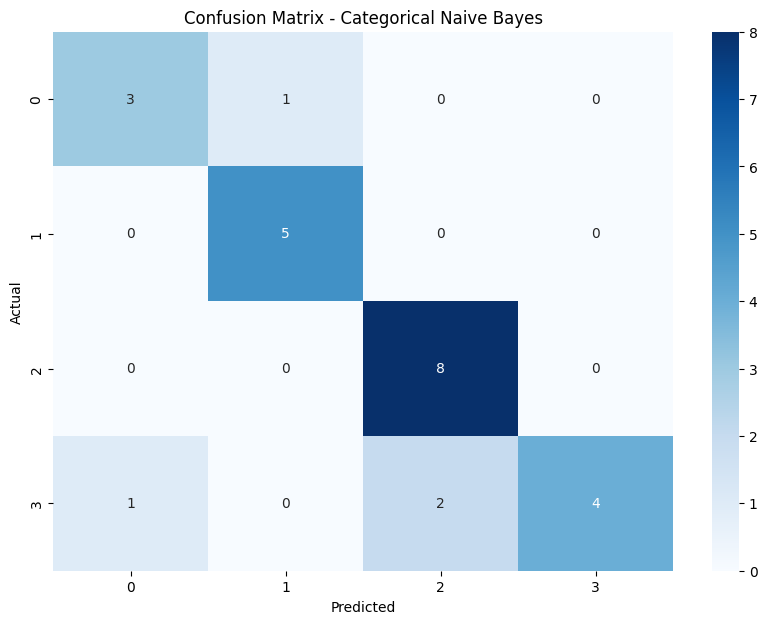

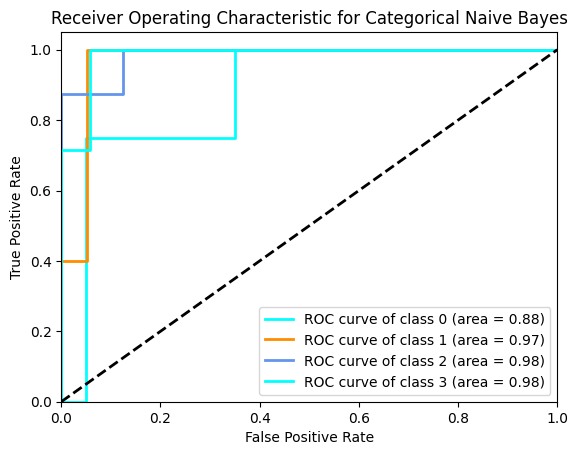

--- Gaussian Naive Bayes ---
Accuracy: 0.7083333333333334
Precision: 0.6059659090909091
Recall: 0.7083333333333334
F1 Score: 0.6354026090868196
Confusion Matrix:
 [[0 3 0 1]
 [0 5 0 0]
 [0 0 8 0]
 [0 0 3 4]]


/home/jerlshin/ENV/env_torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


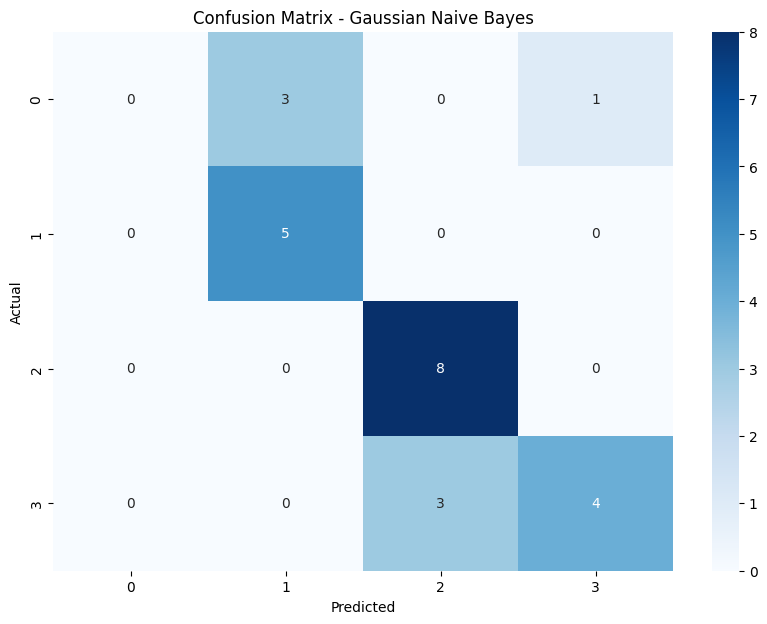

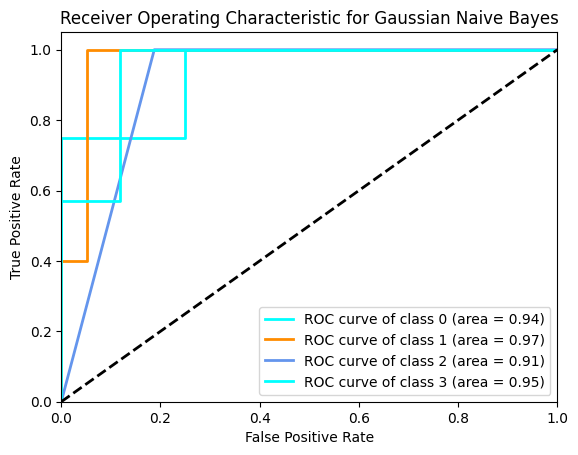

--- Decision Tree Classifier ---
Accuracy: 0.7916666666666666
Precision: 0.8206018518518517
Recall: 0.7916666666666666
F1 Score: 0.76524064171123
Confusion Matrix:
 [[1 2 0 1]
 [0 4 0 1]
 [0 0 8 0]
 [0 0 1 6]]


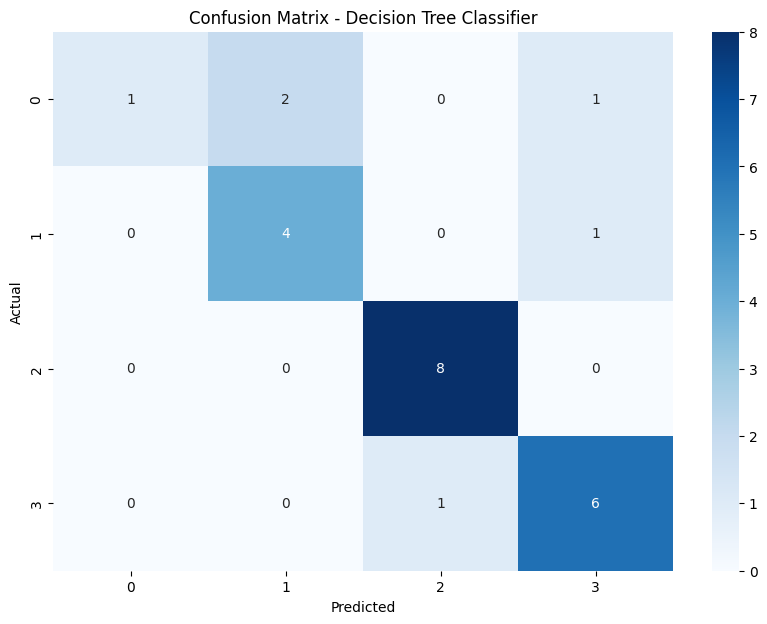

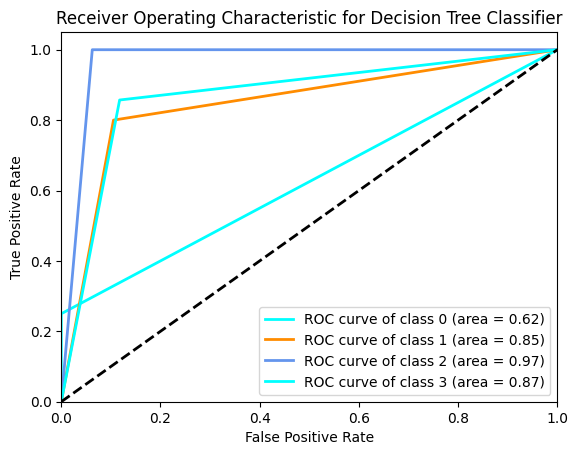


--- Model Comparison ---
                          Accuracy Precision    Recall  F1 Score  \
Categorical Naive Bayes   0.833333  0.856944  0.833333  0.822811   
Gaussian Naive Bayes      0.708333  0.605966  0.708333  0.635403   
Decision Tree Classifier  0.791667  0.820602  0.791667  0.765241   

                                                           Confusion Matrix  
Categorical Naive Bayes   [[3, 1, 0, 0], [0, 5, 0, 0], [0, 0, 8, 0], [1,...  
Gaussian Naive Bayes      [[0, 3, 0, 1], [0, 5, 0, 0], [0, 0, 8, 0], [0,...  
Decision Tree Classifier  [[1, 2, 0, 1], [0, 4, 0, 1], [0, 0, 8, 0], [0,...  


In [ ]:


# Load the dataset
data = pd.read_csv('./Datasets/Categorical 1.csv')

# Separate features and target variable
X = data.drop('Expert Diagnose', axis=1)
y = data['Expert Diagnose']

# Encode the target variable if it's categorical
if y.dtype == 'object':
    y = LabelEncoder().fit_transform(y)

# Identify categorical features
categorical_features = X.select_dtypes(include=['object']).columns

# Create a column transformer with OneHotEncoder for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'  # Keep the remaining columns as they are
)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Categorical Naive Bayes': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', CategoricalNB())
    ]),
    'Gaussian Naive Bayes': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', GaussianNB())
    ]),
    'Decision Tree Classifier': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(random_state=42))
    ])
}

# Store results for comparison
results = {}

# Train, predict, and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Make predictions

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Store results
    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Confusion Matrix': conf_matrix
    }

    # Print evaluation metrics
    print(f"--- {model_name} ---")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:\n", conf_matrix)

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Binarize the output for ROC curve computation
    y_test_bin = label_binarize(y_test, classes=range(len(set(y))))
    n_classes = y_test_bin.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Check if predict_proba method is available
    try:
        y_prob = model.predict_proba(X_test)
    except AttributeError as e:
        print("Error in predict_proba for", model_name, ":", e)
        y_prob = np.zeros((X_test.shape[0], n_classes))

    # Compute ROC curves
    for i in range(n_classes):
        if len(np.unique(y_test_bin[:, i])) < 2:
            print(f"Not enough classes for ROC curve computation for class {i} in {model_name}")
            fpr[i], tpr[i], roc_auc[i] = [np.nan], [np.nan], np.nan
        else:
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    if np.any(np.isnan(y_prob)):
        fpr["micro"], tpr["micro"], roc_auc["micro"] = [np.nan], [np.nan], np.nan
    else:
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot all ROC curves
    plt.figure()
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        if not np.isnan(roc_auc[i]):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                           ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Compare the results
comparison_df = pd.DataFrame(results).T
print("\n--- Model Comparison ---")
print(comparison_df)
